In [1]:
# Import necessary modules and libraries

# Part 1

import datetime as dt
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import fiona
import rasterio.mask
import numpy as np
import tkinter as tk
import gdal
import rasterio
import ogr
import warnings
import json
import datetime
import scipy.spatial
from shapely.geometry import Point, Polygon
from pandas import DataFrame as df
from rasterio.fill import fillnodata
from rasterstats import zonal_stats
from tkinter import filedialog, messagebox
from earthpy import clip
from shapely.geometry import JOIN_STYLE
from geopandas import GeoSeries, GeoDataFrame
from math import ceil
from shapely.ops import unary_union, Polygon
from pathlib import Path
%matplotlib inline
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

# SECTION 1: Creating Agro Maps per crop

This notebook uses input data from <a href="https://www.mapspam.info/data/">MAP SAM</a>. The scope is to extract all crops available at the desired resolution (admin level 2) merge with spatial admin layer and produce output that can later on be used in the downscaling process.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos), [Oluchi Monwe](https://github.com/oluchee) <br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

## Part 1. Creating csv files per crop

In [2]:
# Import agricultural data 

#path = r"C:\Oluchi\Benin\ben_spam_csv"
path = "C:\Oluchi\Benin"
name_of_file = "ben_spam.csv"
# Import csv as pandas dataframe
input_file= pd.read_csv(path + "\\" + name_of_file)

In [3]:
print ("The number of administrative areas (level 2) is {}, as shown below:".format(input_file.name_adm2.nunique()))
input_file.name_adm2.unique()

The number of administrative areas (level 2) is 76, as shown below:


array(['Karimama', 'Malanville', 'Banikoara', 'Tanguieta', 'Kandi',
       'Segbana', 'Kerou', 'Gogounou', 'Materi', 'Kouande',
       'Toukountouna', 'Kobli', 'Kalale', 'Sinende', 'Bembereke',
       'Pehonko', 'Boukoumbe', 'Natitingou', 'Nikki', 'Djougou',
       'Kopargo', 'Ndali', 'Ouake', 'Perere', 'Tchaourou', 'Bassila',
       'Parakou', 'Ouesse', 'Bante', 'Glazoue', 'Save', 'Savalou',
       'Dassa', 'Djidja', 'Ketou', 'Cove', 'Zangnanado', 'Aplahoue',
       'Za-kpota', 'Abomey', 'Bohicon', 'Klouekanme', 'Agbangnizoun',
       'Zogbodome', 'Ouinhi', 'Adja-ouere', 'Pobe', 'Lalo', 'Djakotome',
       'Toviklin', 'Toffo', 'Ze', 'Bonou', 'Sakete', 'Dogbo-tota',
       'Adjohoun', 'Lokossa', 'Bopa', 'Allada', 'Ifangni', 'Athieme',
       'Houeyogbe', 'Kpomasse', 'Tori-bossito', 'Abomey-calavi', 'Dangbo',
       'Avrankou', 'Come', 'So-ava', 'Aguegue', 'Porto-novo', 'Adjara',
       'Ouidah', 'Cotonou', 'Seme-kpodji', 'Grand-popo'], dtype=object)

### Extracting crop data per admin 2 to unique datarames

#### Maize

In [4]:
input_file.columns

Index(['iso3', 'prod_level', 'alloc_key', 'cell5m', 'x', 'y', 'rec_type',
       'tech_type', 'unit', 'whea_a', 'rice_a', 'maiz_a', 'barl_a', 'pmil_a',
       'smil_a', 'sorg_a', 'ocer_a', 'pota_a', 'swpo_a', 'yams_a', 'cass_a',
       'orts_a', 'bean_a', 'chic_a', 'cowp_a', 'pige_a', 'lent_a', 'opul_a',
       'soyb_a', 'grou_a', 'cnut_a', 'oilp_a', 'sunf_a', 'rape_a', 'sesa_a',
       'ooil_a', 'sugc_a', 'sugb_a', 'cott_a', 'ofib_a', 'acof_a', 'rcof_a',
       'coco_a', 'teas_a', 'toba_a', 'bana_a', 'plnt_a', 'trof_a', 'temf_a',
       'vege_a', 'rest_a', 'total_a', 'cere_a', 'root_a', 'puls_a', 'oilc_a',
       'mill_a', 'coff_a', 'fruit_a', 'banpl_a', 'crea_date', 'year_data',
       'source', 'name_cntr', 'name_adm1', 'name_adm2'],
      dtype='object')

In [5]:
# Select crop and create subset dataframe
#maize crop is selected : maiz_A
df_maize = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','maiz_a', 'name_cntr', 'name_adm1','name_adm2'])

In [6]:
# Calculate total harvested area
Maize_harv_area_ha_spam = df_maize['maiz_a'].sum()
print("\033[1m" + "Total harvested area for Maize under the selected parameters is:", Maize_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_maize.describe()

Total harvested area for Maize under the selected parameters is: 1086265.0 ha


,alloc_key,cell5m,x,y,maiz_a
count,1.167000e+03,1.167000e+03,1167.000000,1167.000000,1167.000000
mean,9.668367e+06,4.173657e+06,2.359005,9.490181,930.818338
std,1.803879e+05,7.792657e+04,0.627869,1.503247,1298.128571
min,9.322194e+06,4.024113e+06,0.791667,6.291667,0.000000
25%,9.532174e+06,4.114814e+06,1.875000,8.250000,218.250000
50%,9.622188e+06,4.153707e+06,2.375000,9.875000,441.800000
75%,9.817186e+06,4.237946e+06,2.791667,10.625000,1098.550000
max,1.005218e+07,4.339463e+06,3.791667,12.375000,12125.900000


In [7]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_maize["Admin_2_share"] = df_maize['maiz_a'] / Maize_harv_area_ha_spam

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [8]:
# This is the value retrieved from the source
Maize_harv_area_ha_2018 = 1157805

df_maize["Area_Harv_2018"] = df_maize["Admin_2_share"] * Maize_harv_area_ha_2018

In [9]:
df_maize

,iso3,prod_level,alloc_key,cell5m,x,y,maiz_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,BEN,BN01004,9322194,4024113,2.791667,12.375000,144.5,Benin,Alibori,Karimama,0.000133,154.016582
1,BEN,BN01004,9322195,4024114,2.875000,12.375000,370.9,Benin,Alibori,Karimama,0.000341,395.326992
2,BEN,BN01004,9332194,4028433,2.791667,12.291667,92.5,Benin,Alibori,Karimama,0.000085,98.591930
3,BEN,BN01004,9332195,4028434,2.875000,12.291667,49.6,Benin,Alibori,Karimama,0.000046,52.866591
4,BEN,BN01004,9332196,4028435,2.958333,12.291667,0.0,Benin,Alibori,Karimama,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,BEN,BN10009,10042191,4335150,2.541667,6.375000,1534.4,Benin,Oueme,Seme-kpodji,0.001413,1635.453588
1163,BEN,BN10009,10042192,4335151,2.625000,6.375000,4535.0,Benin,Oueme,Seme-kpodji,0.004175,4833.669201
1164,BEN,BN10009,10042193,4335152,2.708333,6.375000,343.7,Benin,Oueme,Seme-kpodji,0.000316,366.335635
1165,BEN,BN09004,10052182,4339461,1.791667,6.291667,5802.0,Benin,Mono,Grand-popo,0.005341,6184.112173


#### Cassava

In [10]:
# Select crop and create subset dataframe
#cassava crop is selected : cass_a
df_cassava = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','cass_a', 'name_cntr', 'name_adm1','name_adm2'])

# Calculate total harvested area for the selected crop
Cassava_harv_area_ha_spam = df_cassava['cass_a'].sum()
print("\033[1m" + "Total harvested area for Cassava under the selected parameters is:",Cassava_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_cassava.describe()

Total harvested area for Cassava under the selected parameters is: 295222.10000000003 ha


,alloc_key,cell5m,x,y,cass_a
count,1.167000e+03,1.167000e+03,1167.000000,1167.000000,1167.000000
mean,9.668367e+06,4.173657e+06,2.359005,9.490181,252.975236
std,1.803879e+05,7.792657e+04,0.627869,1.503247,602.315275
min,9.322194e+06,4.024113e+06,0.791667,6.291667,0.000000
25%,9.532174e+06,4.114814e+06,1.875000,8.250000,7.050000
50%,9.622188e+06,4.153707e+06,2.375000,9.875000,46.900000
75%,9.817186e+06,4.237946e+06,2.791667,10.625000,173.200000
max,1.005218e+07,4.339463e+06,3.791667,12.375000,5851.300000


In [11]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cassava["Admin_2_share"] = df_cassava['cass_a'] / Cassava_harv_area_ha_spam

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [12]:
# This is the value retrieved from the source
Cassava_harv_area_ha_2018 = 280810

df_cassava["Area_Harv_2018"] = df_cassava["Admin_2_share"] * Cassava_harv_area_ha_2018

In [13]:
df_cassava

,iso3,prod_level,alloc_key,cell5m,x,y,cass_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,BEN,BN01004,9322194,4024113,2.791667,12.375000,9.9,Benin,Alibori,Karimama,0.000034,9.416704
1,BEN,BN01004,9322195,4024114,2.875000,12.375000,12.0,Benin,Alibori,Karimama,0.000041,11.414186
2,BEN,BN01004,9332194,4028433,2.791667,12.291667,5.7,Benin,Alibori,Karimama,0.000019,5.421738
3,BEN,BN01004,9332195,4028434,2.875000,12.291667,3.7,Benin,Alibori,Karimama,0.000013,3.519374
4,BEN,BN01004,9332196,4028435,2.958333,12.291667,8.4,Benin,Alibori,Karimama,0.000028,7.989930
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,BEN,BN10009,10042191,4335150,2.541667,6.375000,1929.1,Benin,Oueme,Seme-kpodji,0.006534,1834.925539
1163,BEN,BN10009,10042192,4335151,2.625000,6.375000,5851.3,Benin,Oueme,Seme-kpodji,0.019820,5565.652277
1164,BEN,BN10009,10042193,4335152,2.708333,6.375000,742.8,Benin,Oueme,Seme-kpodji,0.002516,706.538122
1165,BEN,BN09004,10052182,4339461,1.791667,6.291667,97.4,Benin,Mono,Grand-popo,0.000330,92.645144


#### Yam

In [14]:
# Select crop and create subset dataframe
# yam crop is selected : yams_a
df_yams = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','yams_a', 'name_cntr', 'name_adm1','name_adm2'])

# Calculate total harvested area for the selected crop
yams_harv_area_ha_spam = df_yams['yams_a'].sum()
print("\033[1m" + "Total harvested area for Yams under the selected parameters is:",yams_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_yams.describe()

Total harvested area for Yams under the selected parameters is: 213815.4 ha


,alloc_key,cell5m,x,y,yams_a
count,1.167000e+03,1.167000e+03,1167.000000,1167.000000,1167.000000
mean,9.668367e+06,4.173657e+06,2.359005,9.490181,183.217995
std,1.803879e+05,7.792657e+04,0.627869,1.503247,331.212374
min,9.322194e+06,4.024113e+06,0.791667,6.291667,0.000000
25%,9.532174e+06,4.114814e+06,1.875000,8.250000,14.800000
50%,9.622188e+06,4.153707e+06,2.375000,9.875000,81.500000
75%,9.817186e+06,4.237946e+06,2.791667,10.625000,229.200000
max,1.005218e+07,4.339463e+06,3.791667,12.375000,2656.400000


In [15]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_yams["Admin_2_share"] = df_yams["yams_a"] / yams_harv_area_ha_spam

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [16]:
# This is the value retrieved from the source
yams_harv_area_ha_2018 = 216592

df_yams["Area_Harv_2018"] = df_yams["Admin_2_share"] * yams_harv_area_ha_2018

In [17]:
df_yams

,iso3,prod_level,alloc_key,cell5m,x,y,yams_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,BEN,BN01004,9322194,4024113,2.791667,12.375000,0.0,Benin,Alibori,Karimama,0.0,0.0
1,BEN,BN01004,9322195,4024114,2.875000,12.375000,0.0,Benin,Alibori,Karimama,0.0,0.0
2,BEN,BN01004,9332194,4028433,2.791667,12.291667,0.0,Benin,Alibori,Karimama,0.0,0.0
3,BEN,BN01004,9332195,4028434,2.875000,12.291667,0.0,Benin,Alibori,Karimama,0.0,0.0
4,BEN,BN01004,9332196,4028435,2.958333,12.291667,0.0,Benin,Alibori,Karimama,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,BEN,BN10009,10042191,4335150,2.541667,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.0,0.0
1163,BEN,BN10009,10042192,4335151,2.625000,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.0,0.0
1164,BEN,BN10009,10042193,4335152,2.708333,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.0,0.0
1165,BEN,BN09004,10052182,4339461,1.791667,6.291667,0.0,Benin,Mono,Grand-popo,0.0,0.0


#### Cotton


In [18]:
# Select crop and create subset dataframe
#cotton crop is selected : cott_a
df_cotton = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','cott_a', 'name_cntr', 'name_adm1','name_adm2'])

# Calculate total harvested area for the selected crop
cotton_harv_area_ha_spam = df_cotton['cott_a'].sum()
print("\033[1m" + "Total harvested area for Cotton under the selected parameters is:",cotton_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_cotton.describe()

Total harvested area for Cotton under the selected parameters is: 516362.00000000006 ha


,alloc_key,cell5m,x,y,cott_a
count,1.167000e+03,1.167000e+03,1167.000000,1167.000000,1167.00000
mean,9.668367e+06,4.173657e+06,2.359005,9.490181,442.46958
std,1.803879e+05,7.792657e+04,0.627869,1.503247,947.07828
min,9.322194e+06,4.024113e+06,0.791667,6.291667,0.00000
25%,9.532174e+06,4.114814e+06,1.875000,8.250000,0.80000
50%,9.622188e+06,4.153707e+06,2.375000,9.875000,40.30000
75%,9.817186e+06,4.237946e+06,2.791667,10.625000,302.35000
max,1.005218e+07,4.339463e+06,3.791667,12.375000,5732.70000


In [19]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cotton["Admin_2_share"] = df_cotton["cott_a"] / cotton_harv_area_ha_spam

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [20]:
# This is the value retrieved from the source
Cotton_harv_area_ha_2018 = 600000

df_cotton["Area_Harv_2018"] = df_cotton["Admin_2_share"] * Cotton_harv_area_ha_2018

In [21]:
df_cotton

,iso3,prod_level,alloc_key,cell5m,x,y,cott_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,BEN,BN01004,9322194,4024113,2.791667,12.375000,63.6,Benin,Alibori,Karimama,0.000123,73.901643
1,BEN,BN01004,9322195,4024114,2.875000,12.375000,71.4,Benin,Alibori,Karimama,0.000138,82.965052
2,BEN,BN01004,9332194,4028433,2.791667,12.291667,22.8,Benin,Alibori,Karimama,0.000044,26.493042
3,BEN,BN01004,9332195,4028434,2.875000,12.291667,2.9,Benin,Alibori,Karimama,0.000006,3.369729
4,BEN,BN01004,9332196,4028435,2.958333,12.291667,0.0,Benin,Alibori,Karimama,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1162,BEN,BN10009,10042191,4335150,2.541667,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.000000,0.000000
1163,BEN,BN10009,10042192,4335151,2.625000,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.000000,0.000000
1164,BEN,BN10009,10042193,4335152,2.708333,6.375000,0.0,Benin,Oueme,Seme-kpodji,0.000000,0.000000
1165,BEN,BN09004,10052182,4339461,1.791667,6.291667,0.0,Benin,Mono,Grand-popo,0.000000,0.000000


### Exporting crop dataframes into separate csv

This part exports the csv files for the crops identified. These csv files can be used in a GIS environment (e.g. Qgis) and be merged with the admin 2 layer. In case you want to proceed and perform this here using geopandas, please proceed to the following steps.

In [53]:
## Define output path
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified"

df_maize.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Maize_test")))
df_cassava.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Cassava_test")))
df_yams.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_yams_test")))
df_cotton.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_cotton_test")))

In [54]:
df_maize.head()

,iso3,prod_level,alloc_key,cell5m,x,y,maiz_a,name_cntr,name_adm1,NAME_2,Admin_2_share,Area_Harv_2018
0,BEN,BN01004,9322194,4024113,2.791667,12.375000,144.5,Benin,Alibori,Karimama,0.000133,154.016582
1,BEN,BN01004,9322195,4024114,2.875000,12.375000,370.9,Benin,Alibori,Karimama,0.000341,395.326992
2,BEN,BN01004,9332194,4028433,2.791667,12.291667,92.5,Benin,Alibori,Karimama,0.000085,98.591930
3,BEN,BN01004,9332195,4028434,2.875000,12.291667,49.6,Benin,Alibori,Karimama,0.000046,52.866591
4,BEN,BN01004,9332196,4028435,2.958333,12.291667,0.0,Benin,Alibori,Karimama,0.000000,0.000000


## Part 2. Performing spatial join (merge) using geopandas

### Import admin 2 layer

In this case this is a shapefile, but other formats can be accepted here.

In [22]:
#path_shp = r"N:\Agrodem\Downscaling\Input_Data\vectors\FAO_Agro_Map\moz"
path = r"C:\Oluchi\Benin\Admin_boundaries_modified"
name_shp = "ben_admn_2.shp"
admin_2_gdf = gpd.read_file(path + "\\" + name_shp)

In [23]:
admin_2_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'Production', 'geometry'],
      dtype='object')

In [24]:
admin_2_gdf.head(3)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,Production,geometry
0,BEN,Benin,BEN.1_1,Alibori,None,BEN.1.1_1,Banikoara,None,None,Commune,Commune,None,BJ.AL.BA,50419.0,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
1,BEN,Benin,BEN.1_1,Alibori,None,BEN.1.2_1,Gogounou,None,None,Commune,Commune,None,BJ.AL.GO,51512.0,"POLYGON ((419674.404 1165846.849, 419675.796 1..."
2,BEN,Benin,BEN.1_1,Alibori,None,BEN.1.3_1,Kandi,None,None,Commune,Commune,None,BJ.AL.KN,NaN,"POLYGON ((529894.456 1249913.633, 529701.437 1..."


### Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile.

In [25]:
df_maize.rename(columns={"name_adm2":"NAME_2"}, inplace=True)
df_cassava.rename(columns={"name_adm2":"NAME_2"}, inplace=True)
df_yams.rename(columns={"name_adm2":"NAME_2"}, inplace=True)
df_cotton.rename(columns={"name_adm2":"NAME_2"}, inplace=True)

### Creating unique gdfs per crop

In [26]:
admin_2_maize_gdf = admin_2_gdf.merge(df_maize, on="NAME_2")
admin_2_cassava_gdf = admin_2_gdf.merge(df_cassava, on="NAME_2")
admin_2_yams_gdf = admin_2_gdf.merge(df_yams, on="NAME_2")
admin_2_cotton_gdf = admin_2_gdf.merge(df_cotton, on="NAME_2")

### Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

#### Maize

harv_area_2018_ha

In [27]:
admin_2_maize_gdf["tot_dist_area_ha"] = admin_2_maize_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_maize_gdf["Test"] = admin_2_maize_gdf["tot_dist_area_ha"] > admin_2_maize_gdf["Area_Harv_2018"]
admin_2_maize_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
550    True
551    True
552    True
553    True
554    True
Name: Test, Length: 555, dtype: bool>

In [28]:
# Adding new column for the share of harvested area over the total area per district
admin_2_maize_gdf["harv_share_of_tot"] = admin_2_maize_gdf["Area_Harv_2018"] / admin_2_maize_gdf["tot_dist_area_ha"]

#### Cassava

In [29]:
admin_2_cassava_gdf["tot_dist_area_ha"] = admin_2_cassava_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_cassava_gdf["Test"] = admin_2_cassava_gdf["tot_dist_area_ha"] > admin_2_cassava_gdf["Area_Harv_2018"]
admin_2_cassava_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
550    True
551    True
552    True
553    True
554    True
Name: Test, Length: 555, dtype: bool>

In [30]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cassava_gdf["harv_share_of_tot"] = admin_2_cassava_gdf["Area_Harv_2018"] / admin_2_cassava_gdf["tot_dist_area_ha"]

#### Yams

In [31]:
admin_2_yams_gdf["tot_dist_area_ha"] = admin_2_yams_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_yams_gdf["Test"] = admin_2_yams_gdf["tot_dist_area_ha"] > admin_2_yams_gdf["Area_Harv_2018"]
admin_2_yams_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
550    True
551    True
552    True
553    True
554    True
Name: Test, Length: 555, dtype: bool>

In [32]:
# Adding new column for the share of harvested area over the total area per district
admin_2_yams_gdf["harv_share_of_tot"] = admin_2_yams_gdf["Area_Harv_2018"] / admin_2_yams_gdf["tot_dist_area_ha"]

#### Cotton

In [33]:
admin_2_cotton_gdf["tot_dist_area_ha"] = admin_2_cotton_gdf['geometry'].to_crs({'init': 'epsg:32631'})\
                .map(lambda p: p.area / 10**4)
admin_2_cotton_gdf["Test"] = admin_2_cotton_gdf["tot_dist_area_ha"] > admin_2_cotton_gdf["Area_Harv_2018"]
admin_2_cotton_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
550    True
551    True
552    True
553    True
554    True
Name: Test, Length: 555, dtype: bool>

In [34]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cotton_gdf["harv_share_of_tot"] = admin_2_cotton_gdf["Area_Harv_2018"] / admin_2_cotton_gdf["tot_dist_area_ha"]

### Cleaning the gdfs

In [35]:
admin_2_maize_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'Production', 'geometry', 'iso3', 'prod_level', 'alloc_key', 'cell5m',
       'x', 'y', 'maiz_a', 'name_cntr', 'name_adm1', 'Admin_2_share',
       'Area_Harv_2018', 'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [36]:
# Maize
admin_2_maize_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "NAME_2":"admin2",
                                  "maiz_A":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_maize_gdf = admin_2_maize_gdf.drop(['GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2'], axis=1)

# Cassava
admin_2_cassava_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "NAME_2":"admin2",
                                  "cass_a":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cassava_gdf = admin_2_cassava_gdf.drop(['GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2'], axis=1)


# Yams
admin_2_yams_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "NAME_2":"admin2",
                                  "yams_a":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_yams_gdf = admin_2_yams_gdf.drop(['GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2'], axis=1)

# Cotton
admin_2_cotton_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "NAME_2":"admin2",
                                  "cotton_a":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cotton_gdf = admin_2_cotton_gdf.drop(['GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2'], axis=1)


### Quick visualization of results

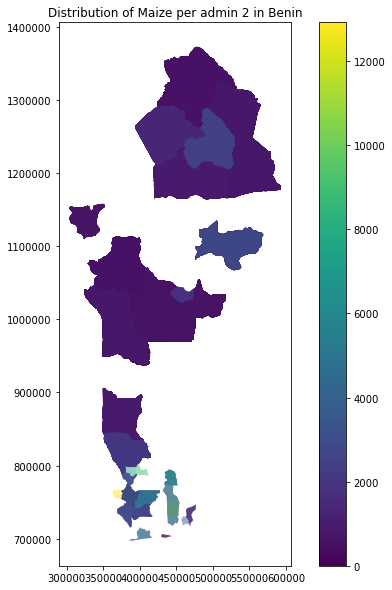

In [37]:
#Maize

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_maize_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Maize"))

# Save plot as figure 
plt.savefig('Maize_Harv_Area_2018.png', bbox_inches='tight')

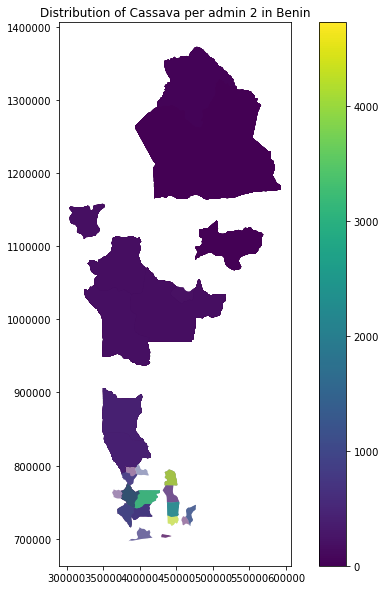

In [38]:
# Cassava

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cassava_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Cassava"))

# Save plot as figure 
plt.savefig('Cassava_Harv_Area_2018.png', bbox_inches='tight')

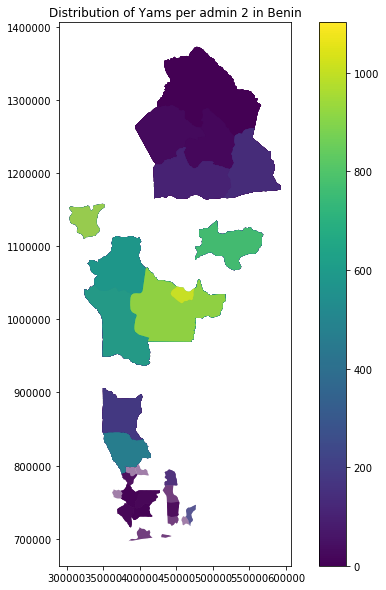

In [39]:
# Yams

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_yams_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Yams"))

# Save plot as figure 
plt.savefig('Yams_Harv_Area_2018.png', bbox_inches='tight')

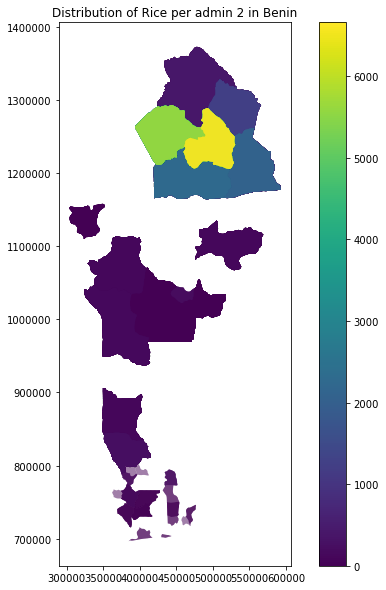

In [40]:
# Cotton

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cotton_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Rice"))

# Save plot as figure 
plt.savefig('Cotton_Harv_Area_2018.png', bbox_inches='tight')

### Exporting gdfs to shapefiles (shp)

In [41]:
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps"

#Maize
admin_2_maize_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_Maize_2018_admin2")))

#Cassava
admin_2_cassava_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_Cassava_2018_admin2")))

#Dry beans
admin_2_yams_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_yams_2018_admin2")))

#Rice paddy
admin_2_cotton_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_cotton_2018_admin2")))

### Exporting gdfs to shapefiles (csv)

In [42]:
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps"


#Maize
admin_2_maize_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Maize_2018_admin2")))

#Cassava
admin_2_cassava_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Cassava_2018_admin2")))

#Dry beans
admin_2_yams_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_yams_2018_admin2")))

#Rice paddy
admin_2_cotton_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_cotton_2018_admin2")))

# SECTION 2: Creating  a grid-base-map of desired output spatial resolution

# Selecting Datasets
Select the workspace, this is the folder that will be used for the outputs. 
NOTE Select an empty folder as all the files will be deleted from the workspace 

You will also have to select the two datasets used in the analysis. These are:
    
1) Administrative boundaries.

2) Agro Maps

In [43]:
#Output folder - Ideally, should be found in Output_data\FAO_AgroMap_Crops
messagebox.showinfo('AGRODEM Creating base grid', 'Output folder')
workspace = filedialog.askdirectory()

#Administrative boundaries - Ideally, should be found in Input_Data/admin_data
messagebox.showinfo('AGRODEM Creating base grid', 'Select the administrative boundaries')
filename_admin = (filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
admin=gpd.read_file(filename_admin)

#The output file of step 1 -  "Prepping_Agro_Maps.ipynb" is what should be used here. It should easily be found in Outputdata/Crop_Maps
messagebox.showinfo('AGRODEM Creating base grid', 'Select the agro map. This should be the output of the Section 1: Creating Agro Maps Section')
filename_agro = (filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
agro=gpd.read_file(filename_agro)

In [44]:
agro.head()

,country_co,country,admin2,VARNAME_2,TYPE_2,Production,iso3,prod_level,alloc_key,cell5m,...,y,maiz_a,name_cntr,name_adm1,shareofsum,harv_area_,district_a,Test,shareofdis,geometry
0,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412189,4062988,...,11.625000,568.4,Benin,Alibori,0.000523,605.834085,437677.965476,1,0.001384,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
1,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412190,4062989,...,11.625000,801.5,Benin,Alibori,0.000738,854.285747,437677.965476,1,0.001952,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
2,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412191,4062990,...,11.625000,581.5,Benin,Alibori,0.000535,619.796834,437677.965476,1,0.001416,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
3,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9422188,4067307,...,11.541667,0.0,Benin,Alibori,0.000000,0.000000,437677.965476,1,0.000000,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
4,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9422189,4067308,...,11.541667,605.3,Benin,Alibori,0.000557,645.164271,437677.965476,1,0.001474,"POLYGON ((483285.095 1262585.664, 483460.594 1..."


# Select the target coordinate system


Find the appropriate target crs from:  https://epsg.io/

In [45]:
crs = 'EPSG:32631'

# Ensuring vectors are in the same coordinate system

In [46]:
# reprojecing to target coordinate system written above
def target_crs(vectors,crs,workspace):   
    vectors = vectors.to_crs(crs) 
    vectors.to_file(workspace, driver='ESRI Shapefile')  
    return vectors

agro_pr = agro.to_crs(crs)
admin_pr = admin.to_crs(crs)

# Fix geometries

In [47]:
def fixgeometries(polygon):
    #creates a valid representation of a given invalid geometry without losing any of the input vertices. 
    fix = polygon.buffer(0.001)
    return fix

# Preparing agro maps

In [48]:
#clip agro map to place of interest
clipped_agro = gpd.clip(agro_pr,admin_pr)

#Create a new dataframe of the production in kg. Initial column unit is tonnes (Conversion: 1000kg = 1 tonne).
clipped_agro['Production_kg'] = clipped_agro['Production'] *1000

#Determining yield 
clipped_agro['yield'] =  clipped_agro['Production_kg']  / clipped_agro['harv_area_']   

#Calculating the area of each unit [ha]
clipped_agro['area'] =  (clipped_agro['geometry'].area)/10000

#Calculating the perimeter of each unit [km]
clipped_agro["perimeter"] = (clipped_agro["geometry"].length)/10000

In [52]:
clipped_agro.sum(axis = 0)

country_co       BENBENBENBENBENBENBENBENBENBENBENBENBENBENBENB...
country          BeninBeninBeninBeninBeninBeninBeninBeninBeninB...
admin2           BanikoaraBanikoaraBanikoaraBanikoaraBanikoaraB...
TYPE_2           CommuneCommuneCommuneCommuneCommuneCommuneComm...
Production                                             1.08006e+07
iso3             BENBENBENBENBENBENBENBENBENBENBENBENBENBENBENB...
prod_level       BN01001BN01001BN01001BN01001BN01001BN01001BN01...
alloc_key                                               5345055818
cell5m                                                  2307356543
x                                                          1395.04
y                                                          5441.12
maiz_a                                                      420186
name_cntr        BeninBeninBeninBeninBeninBeninBeninBeninBeninB...
name_adm1        AliboriAliboriAliboriAliboriAliboriAliboriAlib...
shareofsum                                                0.38